In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from jumpadjust import JumpAdjust
from noiseadjust import NoiseAdjust
from volatility import VarianceEstimation
from evaluation import InformationMeasure
from glob import glob 
dfs = []
for f in glob("./mid_1s/??-??_1s.csv.zst"):
    df = pd.read_csv(f, parse_dates=True, index_col=0)
    dfs.append(df)
df = pd.concat(dfs).sort_index()
df = df.loc["2020":"2020-09-02"]

x = df["BTC-USDT_bitfinex"].ffill().bfill().values

In [2]:
jumpadjust = JumpAdjust(x)
jumpadjusted, _ = jumpadjust.truncate_MLE()

In [3]:
import numpy as np 
import scipy
import statsmodels.tsa.stattools as st

def comb(n, k):
    # nCk
    return scipy.special.gamma(n+1)/scipy.special.gamma(k+1)/scipy.special.gamma(n-k+1)

def fracdiff_kernel(order=2.5, tau=1e-2):
    max_k = 1000
    coeffs = []
    for k in range(max_k):
        coeff = (-1)**k * comb(order, k)
        coeffs.append(coeff)
        if abs(coeff) < tau:
            break
    return np.array(coeffs)
    
class NoiseAdjust:
    # Microstructure noise adjust 
    # Returns denoised log-price

    def __init__(self, logprc, K = 60*10):
        self.logprc = logprc
        self.logret = np.diff(self.logprc, append=[logprc[-1]])
        assert self.logprc.shape == self.logret.shape

        self.n = len(self.logprc)
        self.K = K 
    
    def preaveraging(self):
        logret = self.logret.copy()
        window=self.K
        assert 0 < window < len(logret)
        kernel = np.minimum(np.linspace(0, 1, window+2),
                            np.linspace(1, 0, window+2))[1:-1]
        kernel /= kernel.sum()
        logret_preavg = np.convolve(logret, kernel, mode='same')
        logprc_preavg = np.cumsum(logret_preavg)
        assert self.logprc.shape == logprc_preavg.shape
        return logprc_preavg
    
    def fracdiff(self, order=0.2, tau=1e-2):
        # NOTE: Not to be confused with Fractal derivative.
        logprc = self.logprc.copy()
        kernel = fracdiff_kernel(order, tau)
        logprc_preavg = np.convolve(kernel, logprc, mode='same')
        assert self.logprc.shape == logprc_preavg.shape
        return logprc_preavg

    def fracdiff_fit(self):
        # ADF test로 테스트해본 결과, order=0.2정도에서 stationary 해짐.
        for order in np.arange(0, 1, 0.01):
            pvalue = st.adfuller(self.fracdiff(self.logprc, order))[1]
            if pvalue < 0.01:
                break
        return order
    
    def pade(self):
        # pade transform 
        # clip noise
        # inverse pade transform
        raise NotImplementedError

    def benchmark(self):
        # Do not remove noise
        return self.logprc.copy()

<Axes: >

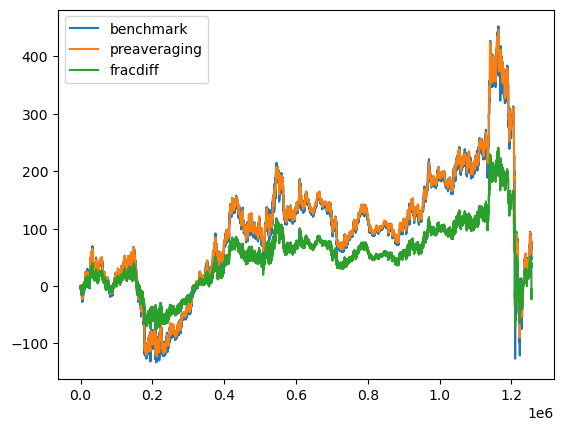

In [4]:
denoise = NoiseAdjust(jumpadjusted, K = 60 * 10)

pd.DataFrame({
    "benchmark": denoise.benchmark(),
    "preaveraging": denoise.preaveraging(),
    "fracdiff": denoise.fracdiff(),
    # "pade" : TODO
}).plot()